In [106]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network trained on selected features to descirbe degree of loss for HCMC

The chance of loss is predicted by classifier. The target variable to predict by the BN are the the degree of relative content loss [fraction of content loss and total content value ] for microbusinesses . \
The transferability of the classifer and the BN is tested on the Can Tho dataset

BN package: https://github.com/mike-mendoza/py_banshee

In [107]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


# sys.path.insert(0, "../")
UTILS_PATH = os.path.join(os.path.abspath(''), '../', 'utils')
sys.path.append(UTILS_PATH)
import settings as s
import figures as f
import evaluation_metrics as em
import preprocessing as pp

seed = s.seed
pd.set_option('display.max_columns', None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

target = "Target_relative_contentloss_euro"

## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/contentloss").mkdir(parents=True, exist_ok=True)


In [108]:
## train set for BN degree of loss (HCMC)
target_name = "contentloss"
df_hcmc_incl_zero = pd.read_excel(f"../model_results/selected_features/degree_of_loss/final_predictors_Target_relative_{target_name}_euro.xlsx")

## drop zero-losses due that they captured by chance of loss , new df only for degree of loss
df_hcmc = df_hcmc_incl_zero.loc[df_hcmc_incl_zero[target] > 0.0, :]

print(df_hcmc.shape)
df_hcmc.tail(2)


# ## load hold out set (HCMC, bred)
# df_hcmc_holdout = pd.read_excel(f"../input_survey_data/input_data_{target_name}_tueb_holdout.xlsx")
# df_hcmc_holdout = df_hcmc_holdout[df_hcmc.columns]  # update only with identified loss-drivers
# # df_hcmc_holdout.drop("geometry", axis=1, inplace=True)
# print(df_hcmc_holdout.shape)
# print(df_hcmc_holdout.tail(2))



(123, 15)


,Target_relative_contentloss_euro,shp_avgmonthly_sale_euro,bage,flowvelocity,precautionary_measures_lowcost,water_depth_cm,resilience,flood_experience,inundation_duration_h,b_area,precautionary_measures_expensive,emergency_measures,shp_employees,contaminations,geometry
303,2.025743,276.2,19.0,0.1,0.25,10,1.000000,151,3.0,50.0,0.0,0.333333,1,1,POINT EMPTY
311,35.796251,736.5,15.0,0.2,1.00,50,2.666667,36,2.0,81.0,0.0,0.500000,1,0,POINT EMPTY


### explore condtional correlations

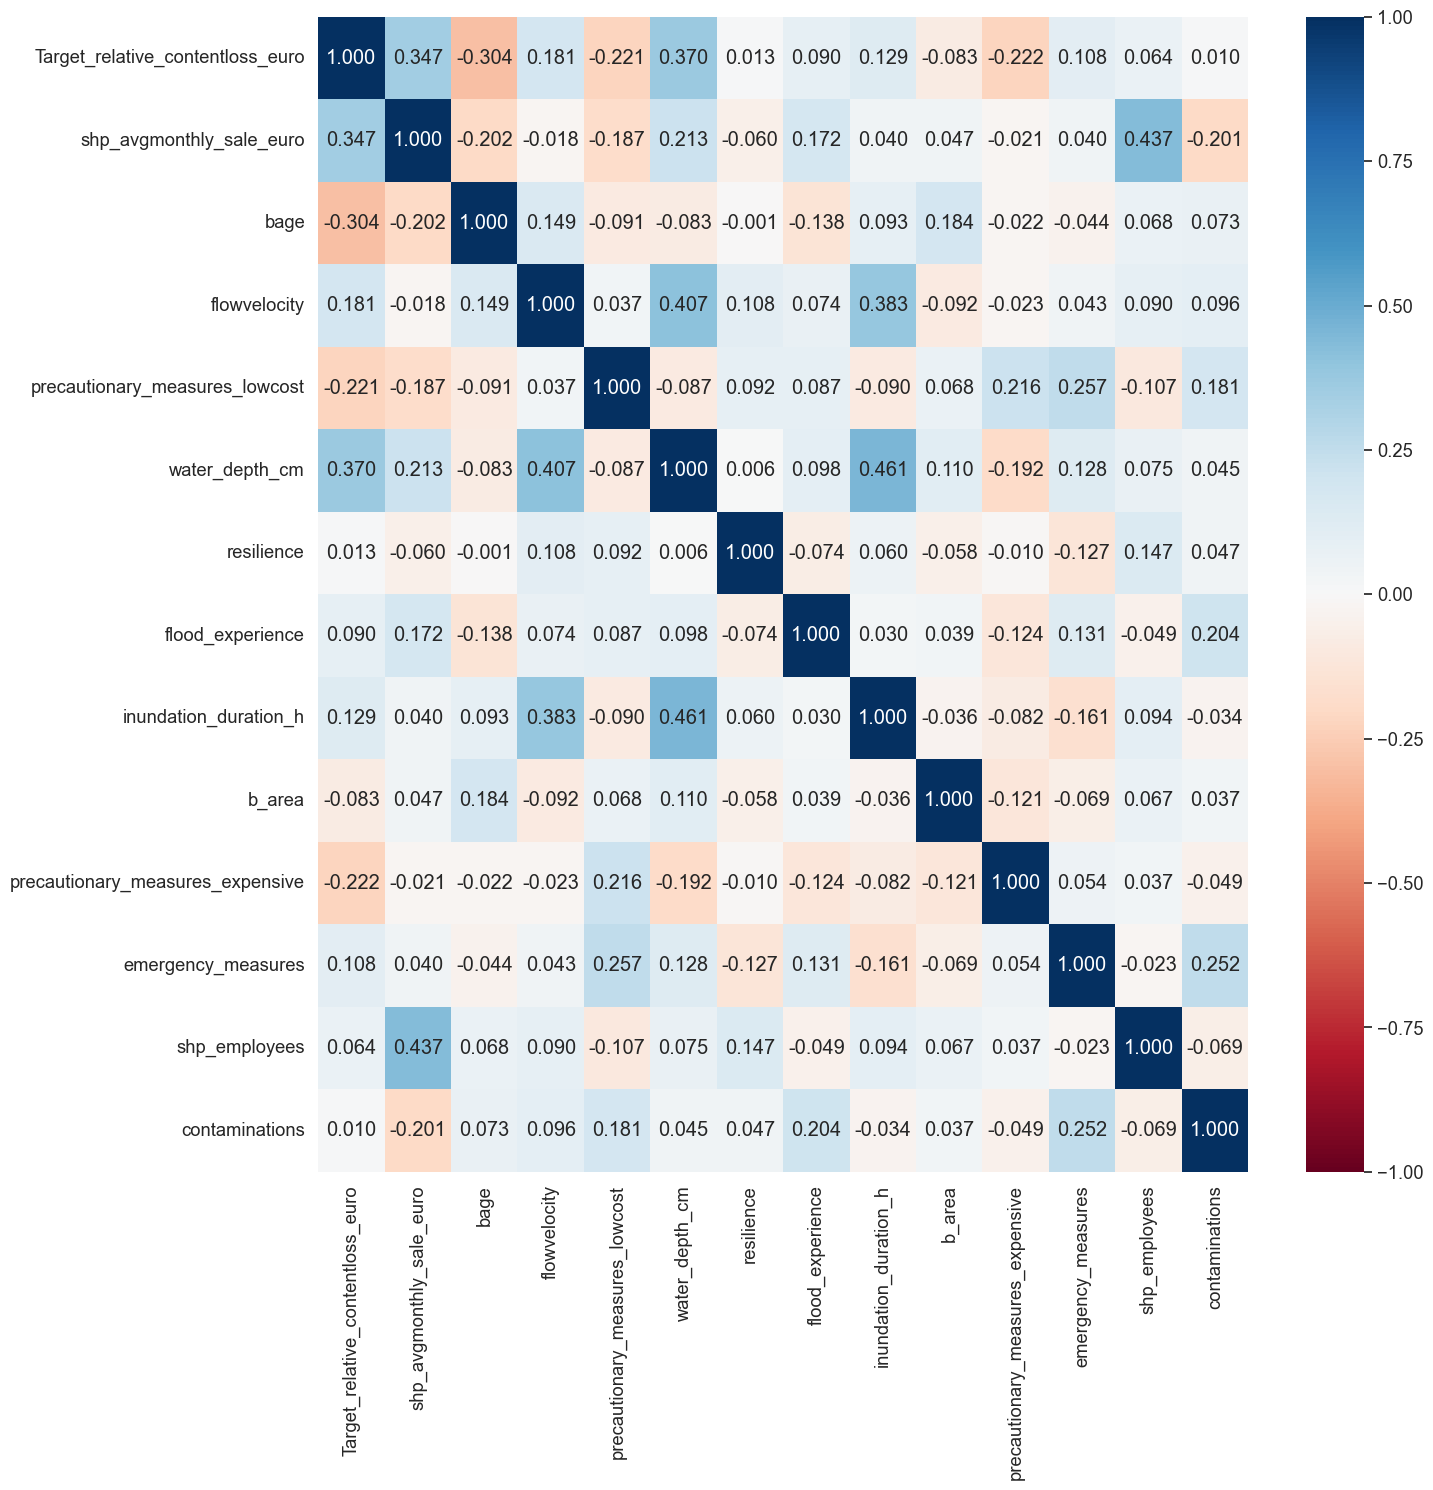

In [109]:
## find predictor with highest unconditional correlation to target
# f.plot_spearman_rank(df_hcmc)
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc.drop("geometry", axis=1).corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")

# fv most corr ~ target


--> flowvelo correlates strongest with rcloss

In [110]:
# dd = df_hcmc.loc[df_hcmc.inundation_duration_h < 20, :]
# print(df_hcmc.shape, dd.shape)
# # sns.regplot(x=dd.flowvelocity, y=dd.inundation_duration_h)
# f.plot_correlations(dd[[target, "flowvelocity", "inundation_duration_h", "water_depth_cm"]], 
#                     impute_na=True, outfile=f"../figures/tst.png")

### Copula test

In [111]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# M = cvm_statistic(df_hcmc,                   # df_predictorsFrame with df_hcmc
#                   names = df_hcmc.columns,   # names of variables
#                   plot = True,               # create a plot (0=don't create plot)
#                   fig_name = "empricial_corpula_all_vars_closs")    # figure name
                  
# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

In [112]:
# M

## Build BN

In [113]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'

# Define the variable names
# names_list = ['Target_relative_contentloss_euro', 'water_depth_cm', 'b_area']# inundation_duration_h
## -> employees -> 

names_list = [
    'Target_relative_contentloss_euro', 'flowvelocity', 
    'shp_avgmonthly_sale_euro', 'bage', #'precautionary_measures_lowcost'
      'water_depth_cm', #'b_area'
    ]
print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

# ## Test log transfomr of rcloss
# df_hcmc_bn[target] = np.log(df_hcmc_bn[target]) * 100
# print(df_hcmc_bn[target].describe())
 
names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['Target_relative_contentloss_euro', 'shp_avgmonthly_sale_euro', 'bage',
       'flowvelocity', 'precautionary_measures_lowcost', 'water_depth_cm',
       'resilience', 'flood_experience', 'inundation_duration_h', 'b_area',
       'precautionary_measures_expensive', 'emergency_measures',
       'shp_employees', 'contaminations', 'geometry'],
      dtype='object')
Using following features: {'Target_relative_contentloss_euro': 0, 'flowvelocity': 1, 'shp_avgmonthly_sale_euro': 2, 'bage': 3, 'water_depth_cm': 4}


In [114]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N


# ### --- Schema kid_cell = parent_cells --- ###

## for OBM + OSM 
# parent_cell[0] = [1, 2] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
# parent_cell[1] = []  # wd
# parent_cell[2] = [] # barea
# # # parent_cell[3] = [] # emplyees or sales

## for Can THo
parent_cell[0] = [1, 2, 3, 4] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
parent_cell[1] = []
parent_cell[2] = []
parent_cell[3] = []
parent_cell[4] = [1]


## check conditional spearman correlations of features: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

5


[[1, 2, 3, 4], [], [], [], [1]]

<Figure size 500x500 with 0 Axes>

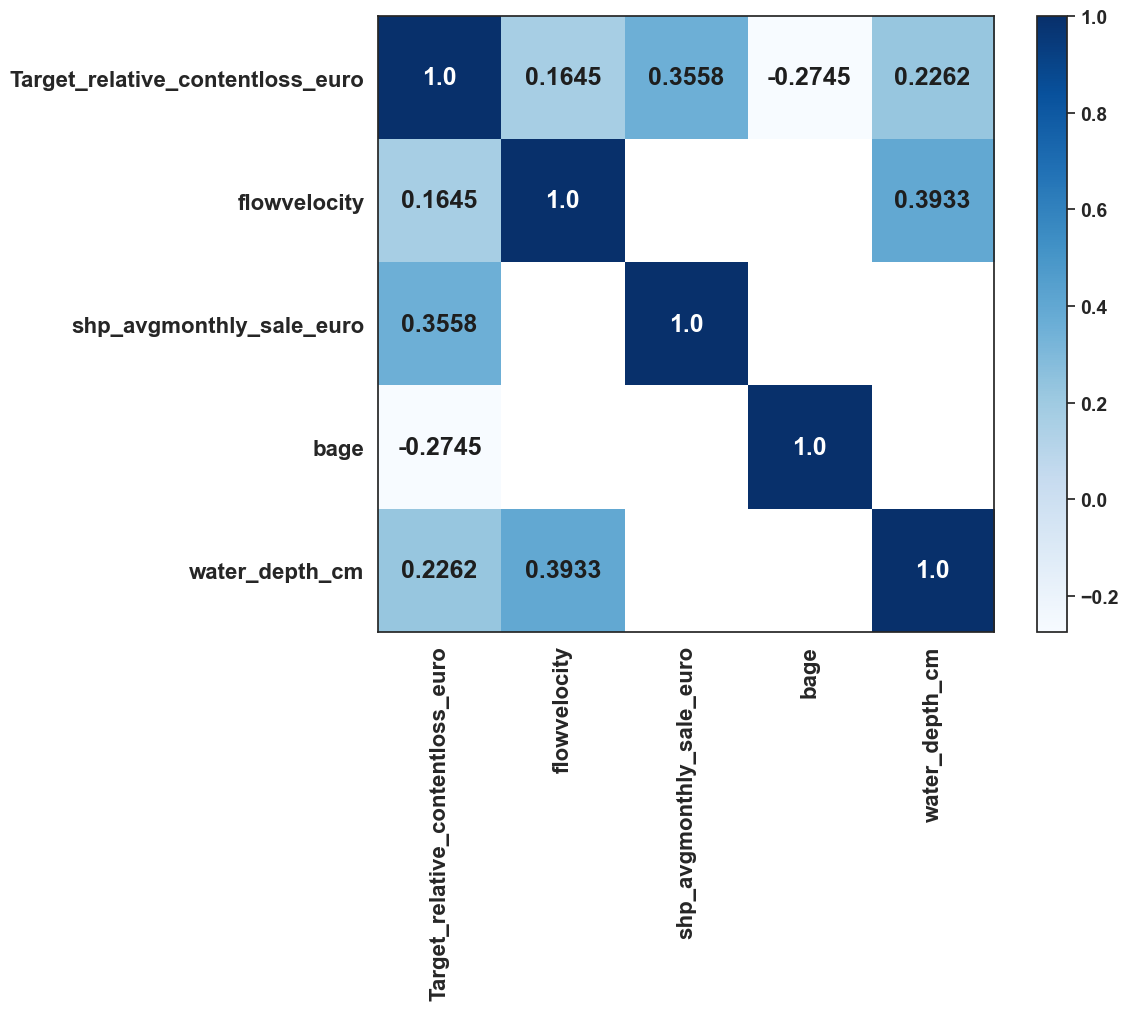

In [115]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.

# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

## Evaluation of degree of damage

In [116]:
# condition=[1, 2]
condition=[1, 2, 3, 4]

num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)

df_hcmc_bn_shuffle = df_hcmc_bn.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals = pd.DataFrame()


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn_shuffle[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_bn_shuffle[ ~df_hcmc_bn_shuffle.index.isin(test_nth_fold.index)] # 80% train
    # print(df_hcmc_bn_shuffle.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # derive rank correlations from training set of nth fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    # estimate loss on test set of nth fold
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        
                Output='mean')    # type of output data, return averge of 
                #Output='median')    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # observed target
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals = pd.concat([residuals, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = em.mean_absolute_error(y_true, y_pred)
    MBE = em.mean_bias_error(y_true, y_pred)
    RMSE = em.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = em.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

residuals.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)




# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


Scores from fold 0: 24.58051759161232 -12.5807023689488 29.171411201018948 64.68778878521306
Inference - Uncertainty distribution, fold 0:  count    24.000000
mean     28.776764
std      18.455706
min       4.659603
25%      16.877659
50%      25.650578
75%      38.524414
max      91.772324
dtype: float64
Scores from fold 1: 10.619750930155956 -7.003797497985296 14.499603865214345 50.9479210363477
Inference - Uncertainty distribution, fold 1:  count    24.000000
mean     15.208410
std      10.813466
min       3.207676
25%       7.556175
50%      12.366460
75%      23.566244
max      45.313850
dtype: float64
Scores from fold 2: 13.8505503988916 -6.9430287997777995 18.81015235465707 55.04260976141839
Inference - Uncertainty distribution, fold 2:  count    24.000000
mean     17.870213
std      12.651392
min       3.479786
25%       8.621499
50%      15.289588
75%      23.504509
max      57.729358
dtype: float64
Scores from fold 3: 14.395741800419229 -6.271222725027592 18.784160842052607 5

In [117]:
F_test_nth_fold.iloc[:,0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### plot obs ~ pred

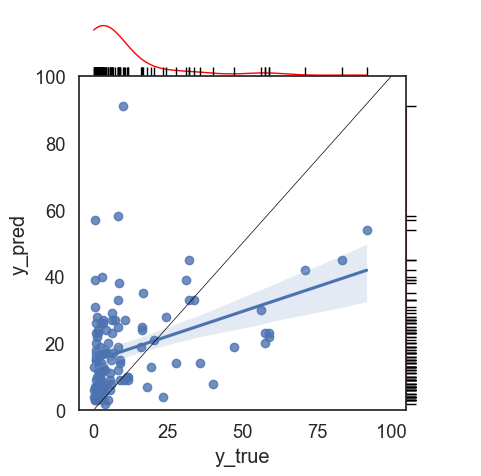

In [ ]:
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(
    x=residuals["y_true"], y=residuals["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

In [ ]:
# bins = np.linspace(0, 100, 100)

# plt.hist(residuals["y_true"], bins, alpha=0.7, label='empirical')
# plt.hist(residuals["y_pred"], bins, alpha=0.7, label='predicted')
# plt.legend(loc='upper right')
# plt.title("Target distributions for degree of loss for HCMC")
# plt.xlim(0,100)
# plt.show()


In [ ]:
print(residuals.describe())


           y_true      y_pred
count  120.000000  120.000000
mean    11.009457   18.016667
std     17.867251   13.770010
min      0.101560    2.000000
25%      1.345986    8.000000
50%      3.432381   15.000000
75%      9.883703   24.000000
max     91.672324   91.000000


#### TODOS : 
- df_cantho_bn.b_area.describe() # TODO reduce bare cantho to 850 sqm 
    --> exploe maybe only drop largest business= NOPE, 
    --> check similiarty index between Cantho ~ hcmc
- fix names for y_true and y_pred for HCMC /cantho for degree loss and rcloss - cantho_y_true_pred_rcloss

# Rcloss estimation

Predict chance and degree of loss on holdout set of HCMC, which was kept unseen from ML and BN models


## predict chance of loss - HCMC


In [ ]:
## load classifier for change of loss

clf_file = "LogisticRegression_Target_relative_contentloss_euro"
# clf_file = "RandomForestClassifier_Target_relative_contentloss_euro"
clf_filepath = rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\model_results\models_trained\chance_of_loss\final_models\{clf_file}.joblib"
clf = load(clf_filepath) 


In [ ]:
# df_hcmc = df_hcmc_holdout.dropna()  # drop incomplete records, needed for Logistic Regression model
df_hcmc_Xy =  df_hcmc.dropna().drop(["geometry", target], axis=1)  # drop incomplete records and geom col, needed for Logistic Regression model
df_hcmc_y = df_hcmc_Xy[target] 
df_hcmc_X = df_hcmc_Xy[['inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'contaminations', 'flood_experience',
       'bage', 'b_area', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'shp_employees', 'resilience', 'shp_avgmonthly_sale_euro']]  # get vars in same order as during fit


KeyError: 'Target_relative_contentloss_euro'

In [ ]:
## predict chance of loss for HCMC

y_hcmc_chance_pred_proba = clf.predict_proba(df_hcmc_X)  # probabilitiies and predicted class

y_hcmc_chance_pred = np.argmax(y_hcmc_chance_pred_proba, axis=1)
y_hcmc_chance_proba = np.take_along_axis(
    y_hcmc_chance_pred_proba, 
    np.expand_dims(y_hcmc_chance_pred, axis=1), 
    axis=1
)
y_hcmc_chance_proba = pd.DataFrame(y_hcmc_chance_proba)#.flatten()


print(f"Actual zero-loss: {len(np.where(df_hcmc[target] == 0)[0])}, \nActual damage: {df_hcmc.loc[df_hcmc[target] > 0.0, : ].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(y_hcmc_chance_pred == 0)[0])}, \nPredict as damage: {len(np.where(y_hcmc_chance_pred == 1)[0])} ")


## idx of all as damage predicted cases
idx_damage = np.where(y_hcmc_chance_pred == 1)[0]

## all cases in HCMC holdout set predicted as damage case --> use this DS as input for BN's interpolation task 
df_hcmc_bn = df_hcmc.iloc[idx_damage, :]
df_hcmc_bn.describe()

## predicted probability that damage occures in HCMC for BN
y_hcmc_chance_proba_damage = y_hcmc_chance_proba.iloc[idx_damage, :]
# 

NameError: name 'df_hcmc_X' is not defined

## predict degree of loss - HCMC

In [118]:
# #-----------------------------------------------------------------------------
# # Function 5 - inference - making inference with the BN model
# #-----------------------------------------------------------------------------

# df_hcmc_bn = df_hcmc_bn[names_list]

# condition=[1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
# values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_bn, # DataFrame with holdout set of HCMC
#               Output='mean')    # type of output data
#              # Output='median')    # type of output data

# # print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

# ## predict target
# bn_y_pred = F.squeeze()

# # Fill out the column(s) which are predicted
# bn_y_true = df_hcmc_bn.iloc[:,0].to_numpy()

# ## store for plotting obs ~ pred
# residuals_per_fold = pd.concat([pd.Series(bn_y_true), pd.Series(bn_y_pred).astype(int)], axis=1)
# residuals = pd.concat([residuals, residuals_per_fold], axis=0)

# # evaluation metrics
# MAE = em.mean_absolute_error(bn_y_true, bn_y_pred)
# MBE = em.mean_bias_error(bn_y_true, bn_y_pred)
# RMSE = em.root_mean_squared_error(bn_y_true, bn_y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
# SMAPE = em.symmetric_mean_absolute_percentage_error(bn_y_true, bn_y_pred)

# print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F.squeeze()).describe())
# # print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())
# print(f"Scores:", MAE, MBE, RMSE, SMAPE) 



# # actual damage cases: Scores from fold 4: 15.675545420081233 -8.743513747913283 22.462360579670868 55.76908532626886


In [119]:
# condition=[1, 2]
condition=[1, 2, 3, 4]

## select only variables used in BN
df_hcmc_bn = df_hcmc_bn[names_list]


num_folds = 3
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)


df_hcmc_bn_shuffle = df_hcmc_bn.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}  # performance errors during cv
residuals = pd.DataFrame()  # store y_true and y_pred 


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn_shuffle[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_bn_shuffle[ ~df_hcmc_bn_shuffle.index.isin(test_nth_fold.index)] # 80% train
    print(df_hcmc_bn_shuffle.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        # DataFrame with df_hcmc
                Output='mean')    # type of output data
                #Output='median')    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals = pd.concat([residuals, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = em.mean_absolute_error(y_true, y_pred)
    MBE = em.mean_bias_error(y_true, y_pred)
    RMSE = em.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = em.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

residuals.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)




# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


(123, 5) (82, 5) (41, 5)
Scores from fold 0: 13.804043335626345 -6.229618195154397 17.122661331919222 52.08620075071962
Inference - Uncertainty distribution, fold 0:  count    41.000000
mean     18.731372
std      10.880599
min       2.027918
25%      11.284725
50%      16.778644
75%      25.308656
max      46.021213
dtype: float64
(123, 5) (82, 5) (41, 5)
Scores from fold 1: 21.20603305469432 -12.421081777133733 28.859869683973656 55.98062113064222
Inference - Uncertainty distribution, fold 1:  count    41.000000
mean     28.462224
std      21.416317
min       5.284151
25%      15.048555
50%      22.201292
75%      32.809194
max      91.772324
dtype: float64
(123, 5) (82, 5) (41, 5)
Scores from fold 2: 10.538863952681107 -6.519688713107924 16.769790918527992 58.961317412856275
Inference - Uncertainty distribution, fold 2:  count    41.000000
mean     12.421009
std      11.892983
min       2.431994
25%       5.419782
50%       9.988703
75%      15.909148
max      71.006425
dtype: float

In [20]:
len(np.where(bn_y_true >= 0.0)[0])  # all observed damage-cases in HMCC

17

In [21]:
bn_degree_true_pred = pd.concat([pd.Series(bn_y_true), pd.Series(bn_y_pred.astype(int))], axis=1)
bn_degree_true_pred.columns = ["y_true", "y_pred"]
bn_degree_true_pred.describe()



,y_true,y_pred
count,17.000000,17.000000
mean,9.717759,22.176471
std,13.076455,5.027864
min,0.240050,16.000000
25%,1.664331,18.000000
50%,3.364471,21.000000
75%,18.097407,25.000000
max,47.067890,32.000000


In [22]:
"""
Comments on binning / categorizing numeric variables

np.histogram which is being used by plt.hist and sns.histplot defines bins to be left closed/inclusive,
except the last bin which is closed on both sides, e.g. [0,1,2,3] results in [[0,1), [1,2), [2,3]].

To be consistent, left closed/inclusive intervals are used as well when categorizing numeric variables with pd.cut.
Methods, which determine bin edges/breaks, also assume subsequent left closed/inclusive binning.
"""

def age_bins(y, bin_size=1):
    # lower bound inclusive
    min_age = math.floor(y[dataset.AGE_ATTRIBUTE].min())
    # upper bound inclusive for histogram plotting, exclusive for categorizing variables
    max_age = math.ceil(y[dataset.AGE_ATTRIBUTE].max())
    return list(range(min_age, max_age + 1))[0::bin_size]


In [24]:


def plot_relative_grid(y_test, y_predict, bin_size=5, **kwargs):
    # Idea: periods with more buildings will not be brighter than periods with little buildings
    bins = utils.age_bins(y_predict, bin_size=bin_size)
    ticks = [1920, 1940, 1960, 1980, 2000]
    X, Y = np.meshgrid(bins, bins)
    age_test = y_test[dataset.AGE_ATTRIBUTE]
    age_predict = y_predict[dataset.AGE_ATTRIBUTE]
    H = np.histogram2d(age_test, age_predict, bins=bins)[0]
    # H_norm: each row describes relative share of all prediction age bands for buildings of a certain test band
    H_norm = (H.T / H.sum(axis=1)).T

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'cadetblue'])
    colors = ['thistle', 'lightsteelblue', 'plum']

    ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color='cadetblue')
    ax_scatter.pcolormesh(X, Y, H_norm, cmap=cmap, rasterized=True)
    ax_scatter.set_yticks(ticks, labels=ticks)
    ax_scatter.set_xticks(ticks, labels=ticks)

    if 'country' in y_predict.columns and 'country' in y_test.columns:
        for i, (_, g) in enumerate(y_predict.groupby('country')):
            ax_hist_x.hist(g[dataset.AGE_ATTRIBUTE], bins=bins, color=colors[i], alpha=0.4)

        for i, (_, g) in enumerate(y_test.groupby('country')):
            ax_hist_y.hist(g[dataset.AGE_ATTRIBUTE], bins=bins, orientation='horizontal', color=colors[i], alpha=0.4)
    else:
        ax_hist_x.hist(y_predict[dataset.AGE_ATTRIBUTE], bins=bins, color=colors[0], alpha=0.4)
        ax_hist_y.hist(y_test[dataset.AGE_ATTRIBUTE], bins=bins, orientation='horizontal', color=colors[0], alpha=0.4)

    ax_hist_x.set_axis_off()
    ax_hist_y.set_axis_off()
    fig.subplots_adjust(hspace=0.05, wspace=0.02)

    ax_scatter.spines['top'].set_linewidth(0.5)
    ax_scatter.spines['right'].set_linewidth(0.5)
    ax_scatter.spines['left'].set_linewidth(0.5)
    ax_scatter.spines['bottom'].set_linewidth(0.5)

    ax_scatter.set_xlabel('Predicted ')
    ax_scatter.set_ylabel('True  ')

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=20)# N=256)

In [25]:
import matplotlib.pyplot as plt

sns.set(style='white', font_scale=1.2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')


g = sns.JointGrid(
    x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 
# cb = fig.colorbar(g, label='counts') # ax=ax 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
                )
density = ax.scatter_density(
    x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
    cmap=white_viridis
)
fig.colorbar(density, label='Number of points per pixel')

x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.suptitle(f"HCMC degree of loss, based on {bn_degree_true_pred.shape[0]} samples")

# hb = ax.hexbin(
#     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
#     gridsize=10, cmap='viridis')
# ax.set(xlim=(0, 100) , ylim=(0, 100) )
# # ax.set_title("Hexagon binning")
# cb = fig.colorbar(hb, ax=ax, label='counts')


plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


ValueError: Unknown projection 'scatter_density'

<Figure size 1000x1000 with 0 Axes>

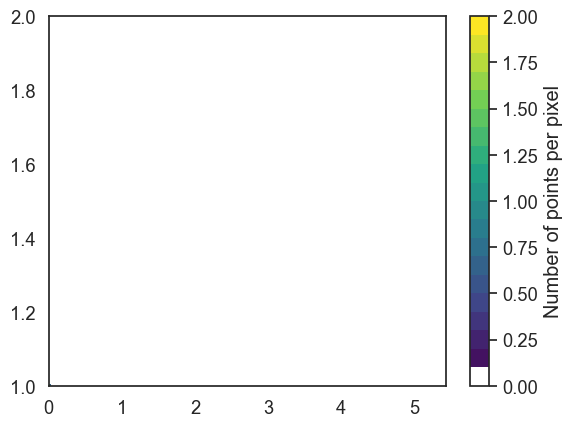

In [ ]:
## Code snippet: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density

import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=20)# N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(
        x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
        cmap=white_viridis
    )
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure()
using_mpl_scatter_density(fig, bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"])
plt.show()

In [26]:
# bins = np.linspace(0, 100, 100)

# plt.hist((pd.Series(bn_y_true.astype(int))), bins, alpha=0.5, label='empirical')
# plt.hist((pd.Series(bn_y_pred.astype(int))), bins, alpha=0.5, label='predicted')
# plt.legend(loc='upper right')
# plt.title("Target distributions for HCMC  - only predicted asdegree of loss(empirical and predicted)")
# plt.show()


### get relative content loss estimations (chance * degree of loss)

In [27]:
y_hcmc_chance_proba.describe()
#bn_degree_true_pred#["y_pred"]

,0
count,114.000000
mean,0.984430
std,0.066369
min,0.636965
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [28]:
## bn_degree_true_pred  # degree of damages
## y_cantho_proba_damage # chance that instance is a damage-case

## reset index of damage cases to match with the index from predicted chance of loss
bn_degree_true_pred.set_index(idx_damage, inplace =True)

## get estimation of relative content loss
y_pred_rcloss = bn_degree_true_pred["y_pred"] * y_hcmc_chance_proba[0].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
## add zero-loss cases
y_pred_rcloss = y_pred_rcloss.fillna(0.0)
y_pred_rcloss

## df with observed rclosses and predicted rclosses
hcmc_y_true_pred_rcloss = pd.concat([df_hcmc_y, y_pred_rcloss], axis=1)
hcmc_y_true_pred_rcloss.columns = ["rcloss_true", "rcloss_pred"]
hcmc_y_true_pred_rcloss.describe()

,rcloss_true,rcloss_pred
count,114.000000,114.000000
mean,11.952305,3.140739
std,19.370894,7.884788
min,0.101560,0.000000
25%,1.336940,0.000000
50%,3.558850,0.000000
75%,10.586663,0.000000
max,91.672324,32.000000


In [29]:
## True Negatives (zero-oss cases wrongly predicted as damage)
tn = hcmc_y_true_pred_rcloss.loc[hcmc_y_true_pred_rcloss.rcloss_pred > 0.0, :]
tn = tn.loc[tn.rcloss_true == 0.0, :]
tn.describe()

,rcloss_true,rcloss_pred
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


# Evaluation of rcloss estimations - HCMC

In [54]:

## TODO fix: remove dropna() 
hcmc_y_true_pred_rcloss = hcmc_y_true_pred_rcloss.dropna()


rcloss_true = hcmc_y_true_pred_rcloss["rcloss_true"]
rcloss_pred = hcmc_y_true_pred_rcloss["rcloss_pred"]

# evaluation metrics
MAE = em.mean_absolute_error(rcloss_true, rcloss_pred)
MBE = em.mean_bias_error(rcloss_true, rcloss_pred)
RMSE = em.root_mean_squared_error(rcloss_true, rcloss_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = em.symmetric_mean_absolute_percentage_error(rcloss_true, rcloss_pred)


print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

import evaluation_metrics as em
em.empirical_vs_predicted(rcloss_true, rcloss_pred)

MAE, MBE, RMSE, SMAPE: 14.414775795078237 9.488804180537068 26.05200179787925 92.0306269026163


,nobs,median,mean,min max,variance,coef_variation
empirical,48,3.5,13.062500,"[0, 91]",523.00,175.074496
predicted,48,0.0,3.916667,"[0, 29]",75.48,221.822637


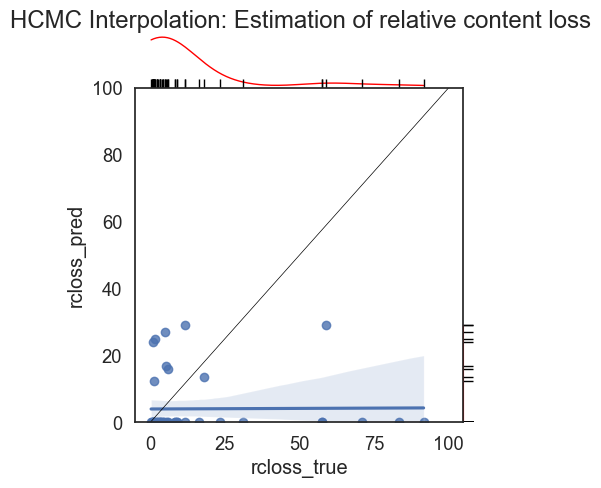

In [31]:
sns.set(style='white', font_scale=1.2)

g = sns.JointGrid(
    x=rcloss_true, 
    y=rcloss_pred, 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
                )
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.suptitle("HCMC Interpolation: Estimation of relative content loss")
plt.show()

#### Main validation results

In [ ]:
## get daamge / total
c = "y_pred"
print(len(np.where(residuals[c] > 0.0)[0])) 
print(len(np.where(residuals[c] > 0.0)[0]) / len(residuals[c]) * 100, "%")
np.mean(residuals[c])


355
100.0 %


0.5859154929577465

In [ ]:
residuals_hcmc = pd.DataFrame(
            {
                "y_true": residuals["y_true"],
                "y_pred": residuals["y_pred"],
                "residuals": residuals["y_true"] - residuals["y_pred"],
            },
            index=residuals["y_true"].index,
        )
print(residuals_hcmc.describe())


for c in residuals_hcmc.columns:
    ci = em.calc_confidence_interval(data=residuals_hcmc[c], confidence_level=0.95)
    counts = ((residuals_hcmc[c].values > ci[0]) & (residuals_hcmc[c].values <= ci[1])).sum(axis=0)
    print(c, "confidence interval:", ci, f"\ncases within interval: {counts}")


          y_true      y_pred   residuals
count  355.00000  355.000000  355.000000
mean    18.04507   18.960563   -0.915493
std     24.79357    9.581858   23.814103
min      0.00000    3.000000 -100.000000
25%      0.00000   12.000000  -15.000000
50%     10.00000   18.000000   -9.000000
75%     30.00000   24.000000    7.500000
max    100.00000  100.000000   91.000000
y_true confidence interval: [15.46 20.63] 
cases within interval: 29
y_pred confidence interval: [17.96 19.96] 
cases within interval: 38
residuals confidence interval: [-3.4   1.57] 
cases within interval: 24


In [32]:

### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
print(em.empirical_vs_predicted(rcloss_true, rcloss_pred))

## get daamge / total
c = "y_pred"
print(len(np.where(residuals[c] > 0.0)[0])) 
print(len(np.where(residuals[c] > 0.0)[0]) / len(residuals[c]) * 100, "%")
np.mean(residuals[c])

           nobs  median       mean  min max  variance  coef_variation
empirical    48     3.5  13.062500  [0, 91]    523.00      175.074496
predicted    48     0.0   3.916667  [0, 29]     75.48      221.822637


In [ ]:
residuals_hcmc = pd.DataFrame(
            {
                "y_true": residuals["y_true"],
                "y_pred": residuals["y_pred"],
                "residuals": residuals["y_true"] - residuals["y_pred"],
            },
            index=residuals["y_true"].index,
        )
print(residuals_hcmc.describe())


for c in residuals_hcmc.columns:
    ci = calc_confidence_interval(data=residuals_hcmc[c], confidence_level=0.95)
    counts = ((residuals_hcmc[c].values > ci[0]) & (residuals_hcmc[c].values <= ci[1])).sum(axis=0)
    print(c, "confidence interval:", ci, f"\ncases within interval: {counts}")


In [ ]:


# # ### Plot prediction error from outer cv
# f.plot_residuals(
#     residuals=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../../model_results/models_evaluation/degree_of_loss/residuals_{target}.png"
# )


In [33]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label='hcmc rcloss')
# plt.hist(df_cantho[target], bins, alpha=0.5, label='cantho rcloss')
# plt.legend(loc='upper right')
# plt.title("Target distributions for both cities (empirical)")
# plt.show()


#### Inference

In [34]:
# #-----------------------------------------------------------------------------
# # Function 5 - inference - making inference with the BN model
# #-----------------------------------------------------------------------------

# condition=[1] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
# values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_bn, # DataFrame with df_hcmc
#              # Output='mean')    # type of output data
#               Output='median')    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

# ## predict target
# y_pred = F.squeeze()

# # Fill out the column(s) which are predicted
# y_true=df_hcmc_bn.iloc[:,0].to_numpy()

# # Calculate coefficient of determination
# A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
# B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
# correlation = (np.dot(B, A.T)/B.shape[0])
# R2=correlation**2

# # Calculate evaluation metrics
# MAE = np.mean(np.abs(y_pred-y_true))
# MBE = np.mean(y_pred-y_true)
# RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

# print("MAE,:", MAE)  
# print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


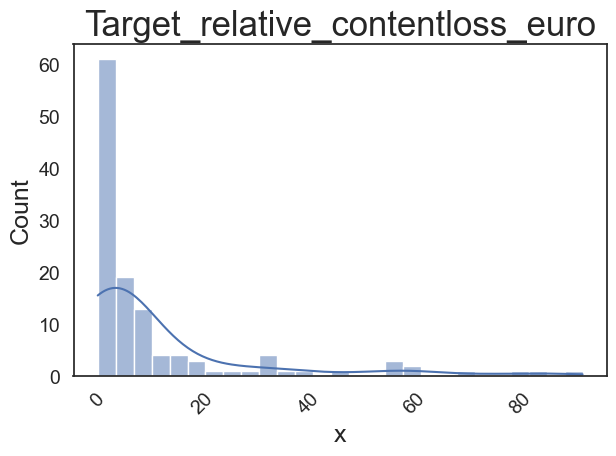

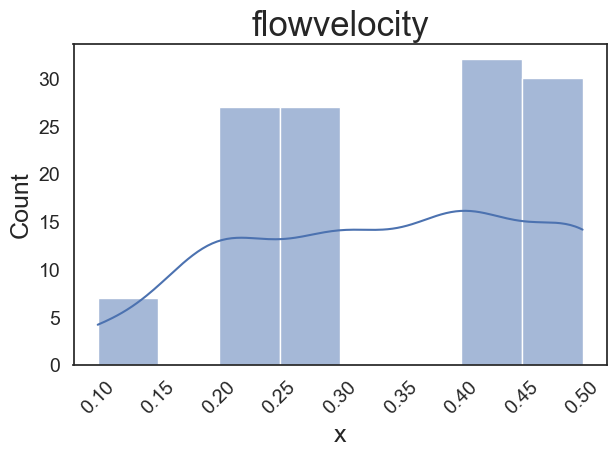

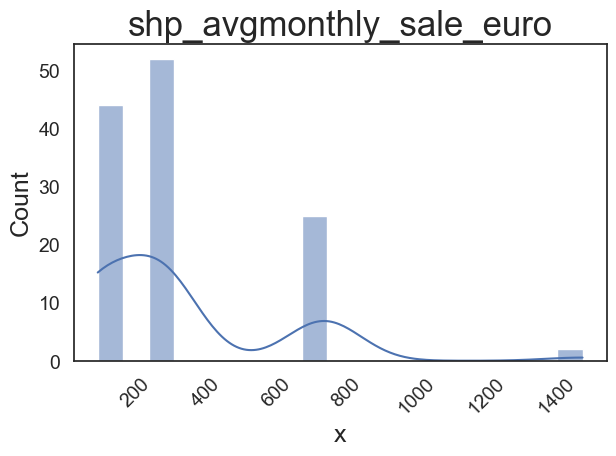

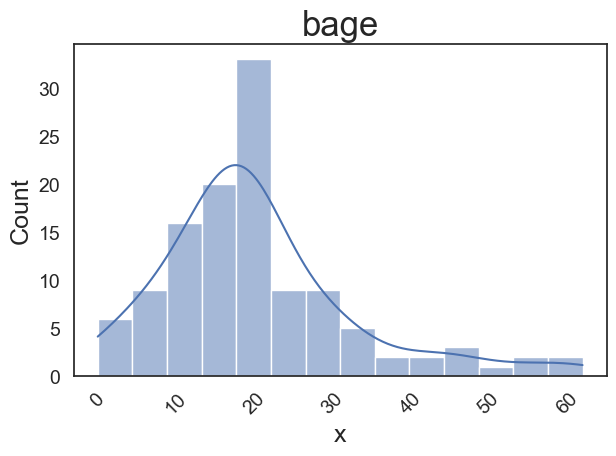

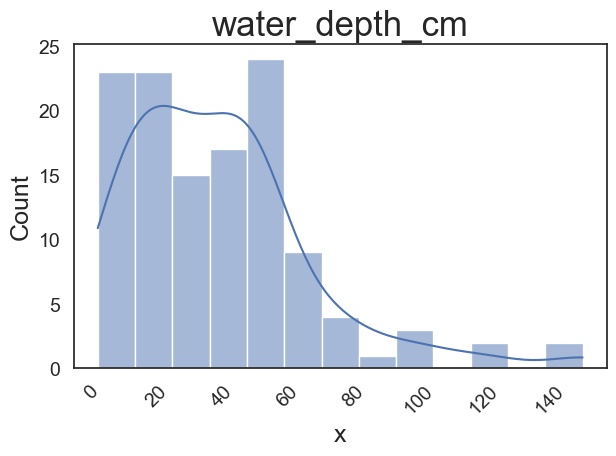

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_relative_contentloss_euro_margins.pdf'

In [35]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn.columns,                      # names of variables
             data = df_hcmc_bn,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


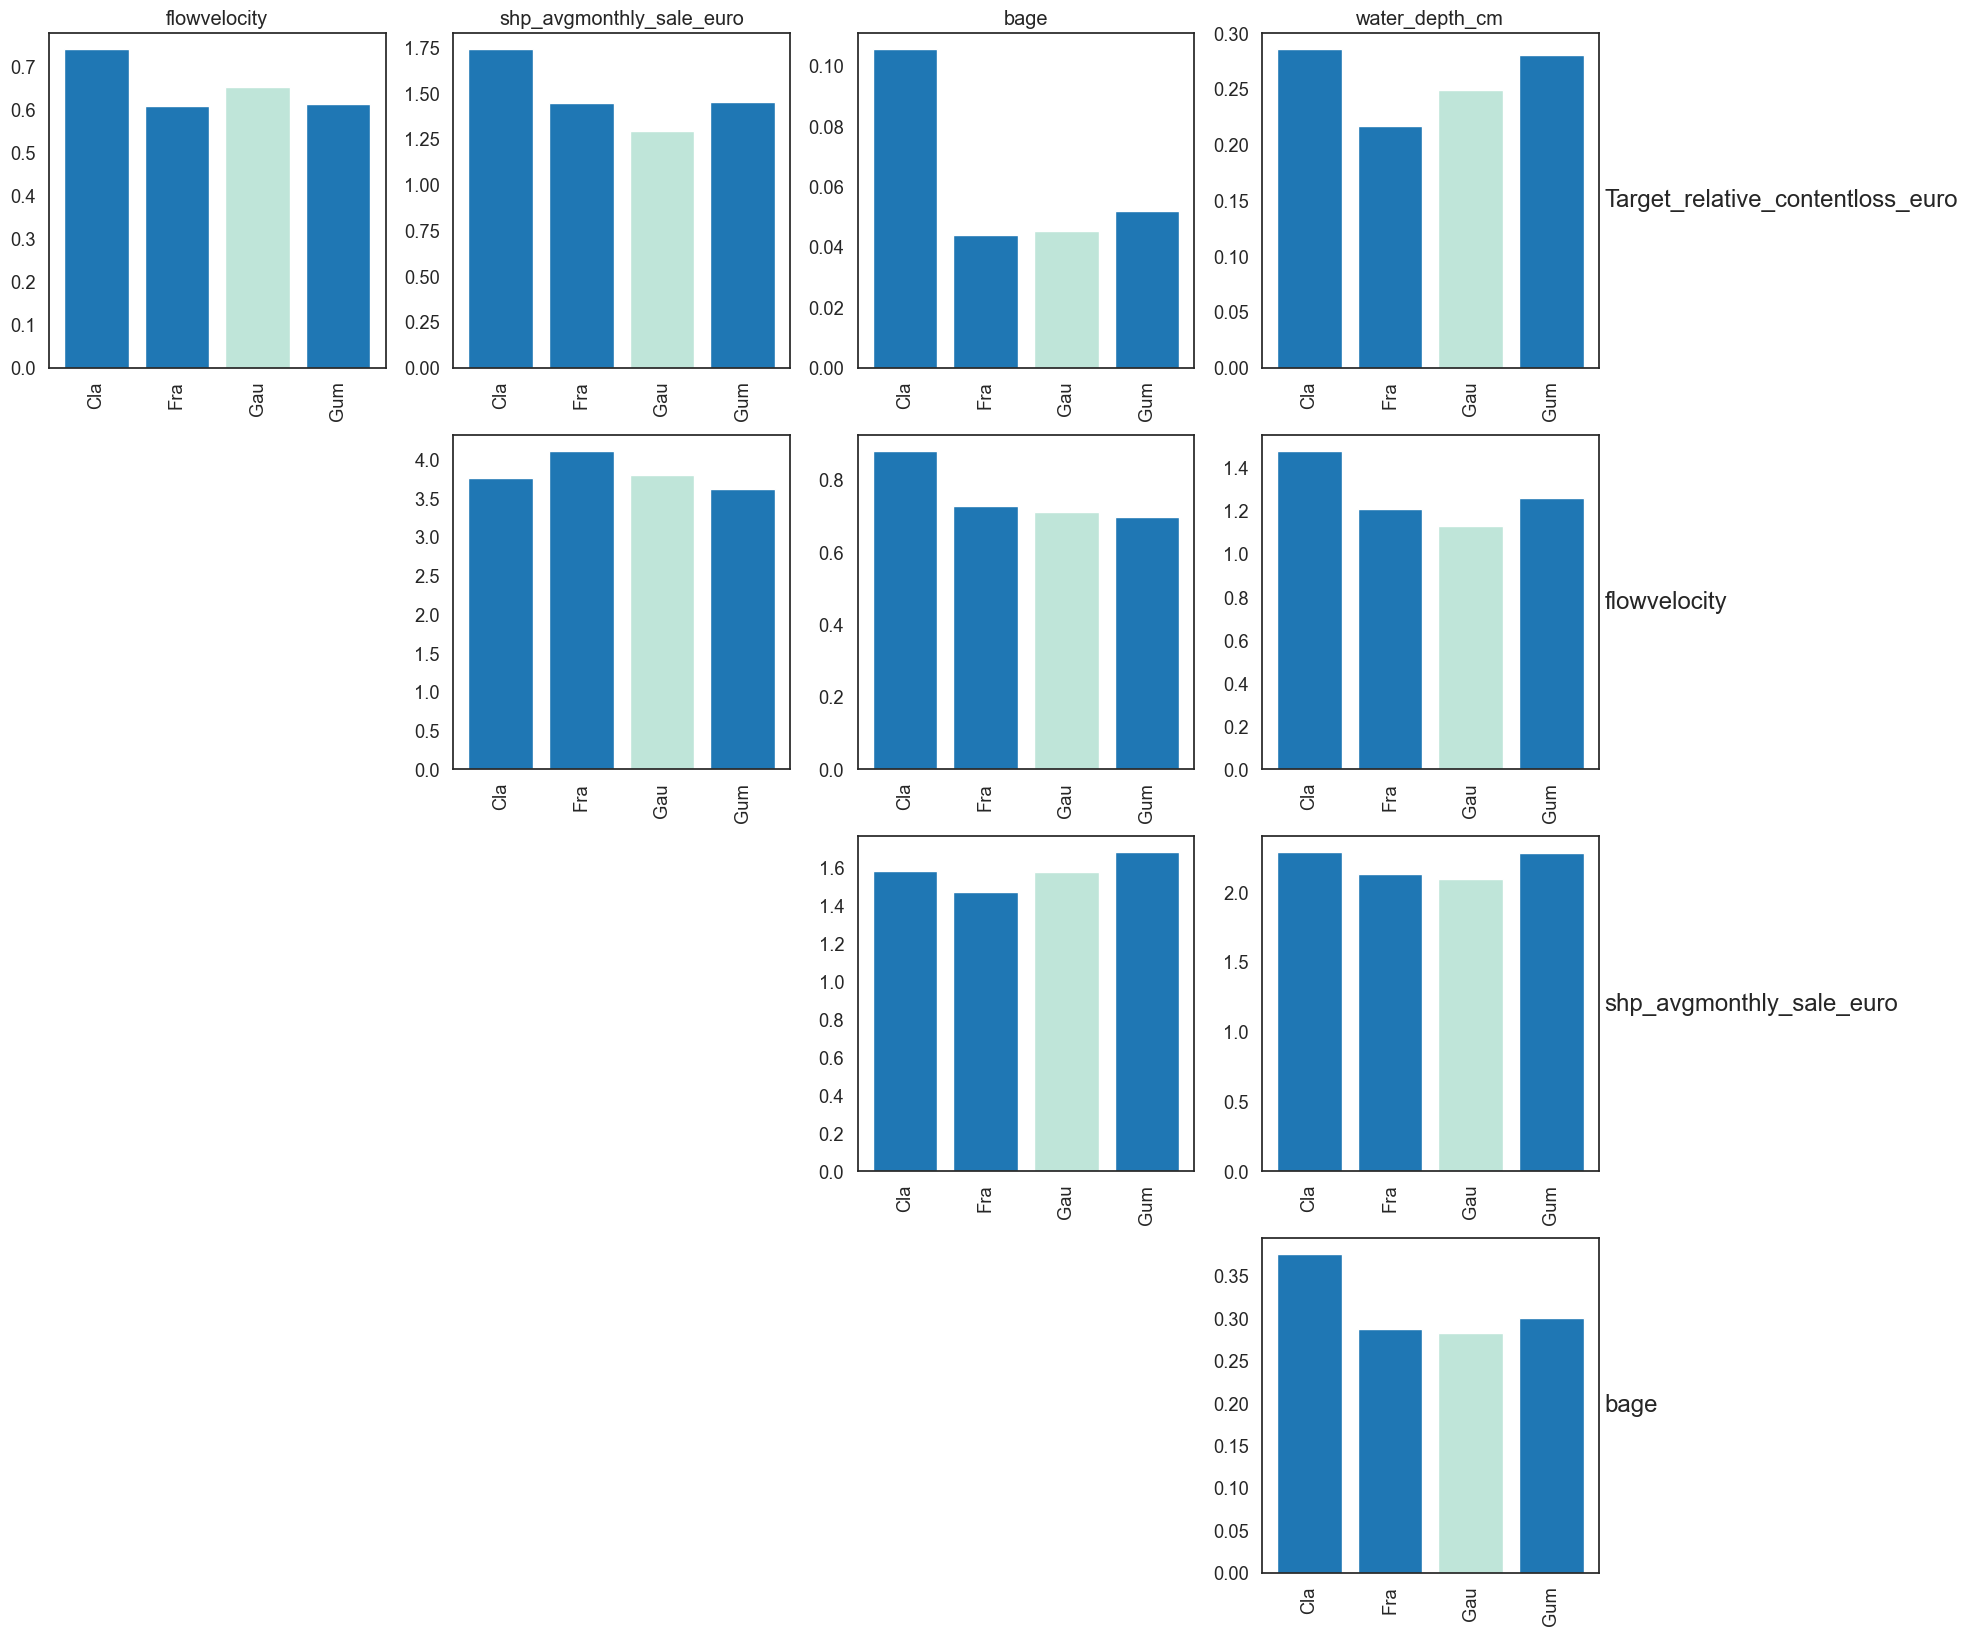

In [36]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

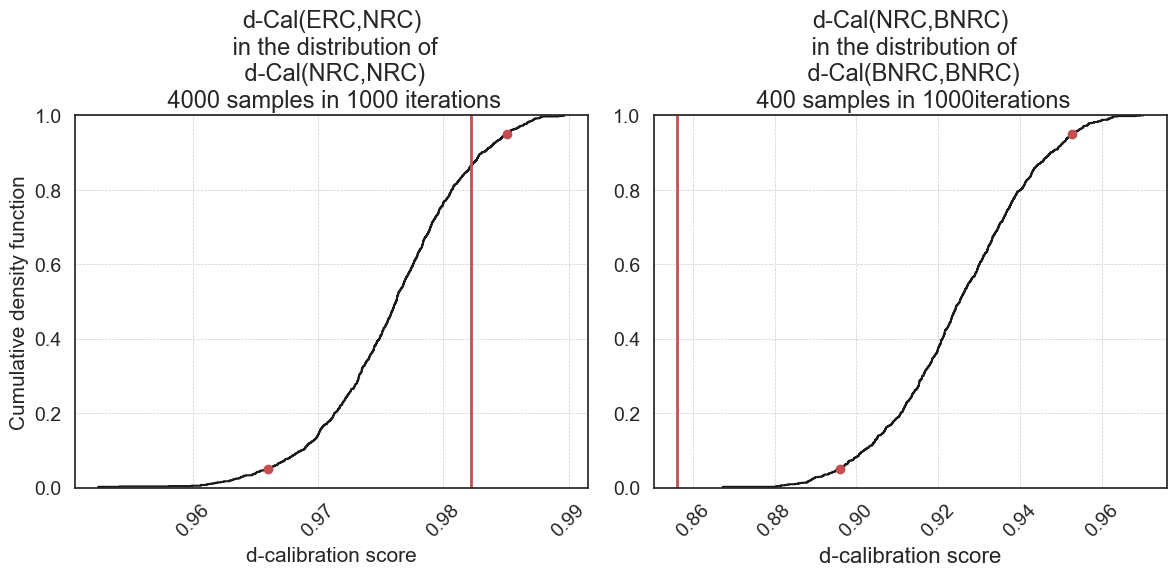

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [37]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don't create plot)
                            Type='H',           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


In [18]:
df_hcmc.head(2)#.shape

,Target_businessreduction,flowvelocity,emergency_measures,water_depth_cm,bage,inundation_duration_h,shp_employees,flood_experience,resilienceLeftAlone,shp_content_value_euro,precautionary_measures_lowcost,b_area,resilience,precautionary_measures_expensive,hh_monthly_income_euro,shp_avgmonthly_sale_euro,contaminations
0,0,0.2,0.0,10.0,12.0,2.0,1,76,2.0,441.9,0.0,25.0,5.0,0.0,110.5,276.2,0
1,0,0.2,0.0,15.0,0.0,2.0,1,76,1.0,441.9,0.0,21.0,5.0,0.0,294.6,276.2,1


# Model transferability
Test trained NPBN for CanTHo DS

In [133]:
## load cantho predictors
infile_name = "input_data_contentloss_cantho"
df_cantho_incl_zero = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

print(df_cantho_incl_zero[target].describe())

## load classifier for change of loss
clf_file = "LogisticRegression_Target_relative_contentloss_euro"
# clf_file = "RandomForestClassifier_Target_relative_contentloss_euro"
clf_filepath = rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\model_results\models_trained\chance_of_loss\final_models\{clf_file}.joblib"
clf = load(clf_filepath) 
clf


count    313.000000
mean       9.656027
std       17.935054
min        0.000000
25%        0.000000
50%        0.000000
75%       10.612845
max       92.950717
Name: Target_relative_contentloss_euro, dtype: float64


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1, l1_ratio=1.0, max_iter=500,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=0.001))])

In [134]:
## large b areas
df_cantho_incl_zero.loc[df_cantho_incl_zero.b_area> 500, :]

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
99,15.468579,1.5,30,0.6,1,16,4.0,640.0,0.222222,0.25,0.000000,1,3,213.7
255,26.562228,4.0,40,0.6,0,8,6.0,2000.0,0.111111,0.25,0.333333,1,3,2992.5
296,0.000000,6.0,20,0.5,1,8,5.0,1242.0,0.000000,0.75,0.333333,1,1,213.7
299,0.000000,5.0,50,0.5,1,76,5.0,1600.0,0.000000,0.25,0.000000,1,2,42.7


In [123]:
## high sale rates
print(df_cantho_incl_zero.shp_avgmonthly_sale_euro.describe())
df_cantho_incl_zero.loc[df_cantho_incl_zero.c > 2500, :]

## -> high sale rates are not an indication for a larger building area or many employees

count      287.000000
mean       475.681533
std       1688.906299
min         12.800000
25%         85.600000
50%        171.000000
75%        384.700000
max      25650.200000
Name: shp_avgmonthly_sale_euro, dtype: float64


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
25,0.000000,6.0,50,0.2,1,76,3.0,100.0,0.333333,0.25,0.666667,5,6,2565.0
31,0.000000,6.0,10,0.4,1,8,3.0,110.0,0.888889,0.00,0.333333,1,1,2565.0
79,27.882109,3.0,10,0.5,1,76,5.0,42.5,0.444444,0.50,0.333333,2,5,2565.0
104,27.895952,6.0,50,0.3,1,76,6.0,86.4,0.555556,0.50,0.333333,7,3,2778.8
164,17.971150,3.0,40,0.5,0,8,5.0,52.0,0.111111,0.00,0.333333,1,2,8977.6
193,39.843343,5.0,10,0.3,1,8,7.0,75.0,0.444444,0.00,0.666667,3,1,25650.2
200,4.648399,5.0,20,0.6,1,8,6.0,64.0,0.000000,0.50,0.000000,5,2,2992.5
243,0.000000,1.0,1,0.6,0,8,6.0,60.0,0.111111,0.50,0.000000,8,3,6412.5
255,26.562228,4.0,40,0.6,0,8,6.0,2000.0,0.111111,0.25,0.333333,1,3,2992.5


In [136]:
pp.percentage_of_nan(df_cantho_incl_zero)

## RF and LogReg cant predict on missing data
print(df_cantho_incl_zero.shape)
df_cantho_incl_zero = df_cantho_incl_zero.dropna()
df_cantho_incl_zero = df_cantho_incl_zero.reset_index(drop=True)
print(df_cantho_incl_zero.shape)



01-03-2024 07:00:03 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 Target_relative_contentloss_euro    0.0
inundation_duration_h               0.0
water_depth_cm                      0.0
flowvelocity                        0.0
contaminations                      0.0
flood_experience                    0.0
bage                                0.0
b_area                              0.0
emergency_measures                  0.0
precautionary_measures_lowcost      0.0
precautionary_measures_expensive    0.0
shp_employees                       0.0
resilience                          0.0
shp_avgmonthly_sale_euro            0.0
dtype: float64


(283, 14)
(283, 14)


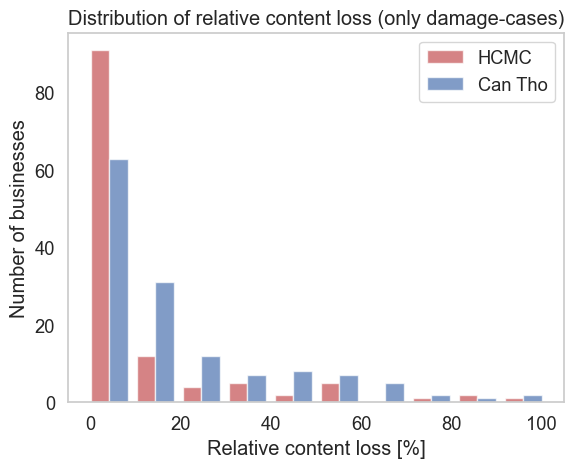

In [137]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_bn["Target_businessreduction"], bins, alpha=0.7, label='HCMC')
#plt.hist(df_cantho["Target_businessreduction"], bins, alpha=0.7, label='Can Tho')
df_cantho_no_zero = df_cantho_incl_zero.loc[df_cantho_incl_zero[target] > 0.0, :]

import seaborn as sns

# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn[target], 
        df_cantho_no_zero[target]
    ], 
    color=['r','b'], alpha=0.7,  
    label=['HCMC', 'Can Tho'],
    bins = np.linspace(-1, 101, 11)
)

# TODO make to 10 bis with equal ranges

plt.legend(loc='upper right')
plt.ylabel("Number of businesses")
plt.xlabel("Relative content loss [%]")
plt.title("Distribution of relative content loss (only damage-cases)")# (source: survey datasets)
plt.show()

### predict chance of loss - CanTho

In [138]:
df_cantho_X = df_cantho_incl_zero.drop(target, axis=1)
df_cantho_y = df_cantho_incl_zero[target]
df_cantho_X


,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
0,3.0,40,0.5,1,76,6.0,60.0,0.444444,0.00,0.000000,1,5,855.0
1,3.0,30,0.6,1,76,5.0,31.5,0.444444,0.25,0.333333,3,1,641.3
2,3.0,20,0.5,1,76,6.0,20.0,0.444444,0.50,0.333333,1,5,641.3
3,4.0,40,0.4,1,76,6.0,49.0,0.222222,0.50,0.000000,2,4,128.3
4,1.0,20,0.4,0,8,7.0,100.0,0.222222,0.75,0.333333,1,1,64.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,3.0,50,0.2,0,76,4.0,30.0,0.111111,0.00,0.000000,1,2,171.0
279,5.0,60,0.2,0,8,5.0,140.0,0.555556,0.50,0.333333,1,2,299.3
280,2.0,20,0.4,1,8,6.0,184.0,0.444444,0.50,0.333333,1,3,85.6
281,3.0,20,0.4,1,8,5.0,150.0,0.444444,0.50,0.666667,4,1,1710.0


In [139]:
## predict chance of loss for CanTho

# y_cantho_pred = clf.predict(df_cantho_X)
y_cantho_pred_proba = clf.predict_proba(df_cantho_X)  # probabilitiies and predicted class

y_cantho_pred = np.argmax(y_cantho_pred_proba, axis=1)
y_cantho_proba = np.take_along_axis(
    y_cantho_pred_proba, 
    np.expand_dims(y_cantho_pred, axis=1), 
    axis=1
)
y_cantho_proba = pd.DataFrame(y_cantho_proba)#.flatten()

# print(y_cantho_proba, y_cantho_pred)

print(f"Actual zero-loss: {len(np.where(df_cantho_incl_zero[target] == 0)[0])}, \nActual damage: {df_cantho_incl_zero.loc[df_cantho_incl_zero[target] > 0.0, : ].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(y_cantho_pred == 0)[0])}, \nPredict as damage: {len(np.where(y_cantho_pred == 1)[0])} ")


Actual zero-loss: 145, 
Actual damage: 138 

Predict as zero-loss: 227, 
Predict as damage: 56 


In [128]:
## idx of all damage cases
idx_damage = np.where(y_cantho_pred == 1)[0]

## all cases in Can THo predicted as damage case --> use this DS as input for BN predcition task 
df_cantho_bn = df_cantho_incl_zero.iloc[idx_damage, :]
df_cantho_bn.describe()

## predicted probability that damage occures in CanTHo for BN
y_cantho_proba_damage = y_cantho_proba.iloc[idx_damage, :]
y_cantho_proba_damage

,0
11,1.000000
12,0.776285
13,0.976531
25,1.000000
31,1.000000
37,1.000000
39,1.000000
42,1.000000
44,1.000000
45,1.000000


### predict degree of loss - CanTho

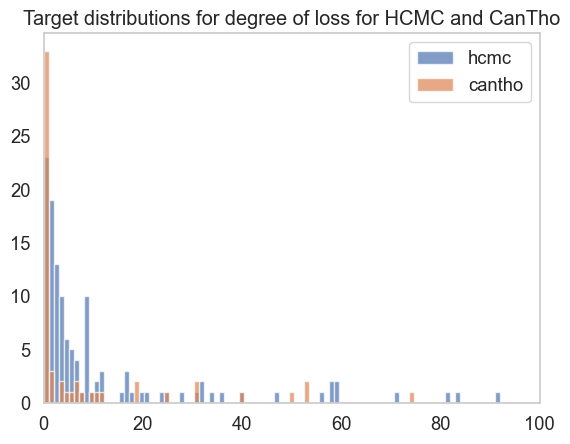

In [129]:
bins = np.linspace(0, 100, 100)

plt.hist(df_hcmc_bn[target], bins, alpha=0.7, label='hcmc')
plt.hist(df_cantho_bn[target], bins, alpha=0.7, label='cantho')
plt.legend(loc='upper right')
plt.title("Target distributions for degree of loss for HCMC and CanTho")
plt.xlim(0,100)
plt.show()


In [48]:
# # ## check for 1.0 valus in cantho 

# df_cantho_bn = df_cantho_bn.reset_index(drop=True)

# # df_cantho_bn = df_cantho_bn.loc[df_cantho_bn.Target_relative_contentloss_euro > 0.5, :]
# # df_cantho_bn[target] =  
# # idx_targetrange = df_cantho_bn[target][ (df_cantho_bn[target] > df_hcmc_bn[target].min()) & (df_cantho_bn[target] < df_hcmc_bn[target].max()) ].index
# idx_targetrange = df_cantho_bn[target][ (df_cantho_bn[target] > 0.2) & (df_cantho_bn[target] < 18)].index
# df_cantho_bn = df_cantho_bn.iloc[idx_targetrange, :]
# df_cantho_bn.describe()

In [53]:
condition=[1, 2, 3, 4]

df_cantho_bn = df_cantho_bn[df_hcmc_bn.columns] # give cantho DF same column order as for HCMC ds, DF inlcudes only predicted damage cases

values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization
# values = df_cantho_bn[df_hcmc_bn.columns].to_numpy() # data for conditionalization, only X, same variables as for BN contructed on HCMC

bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}


# BN build rank correlations from all damage-cases in HCMC dataset
R = bn_rankcorr(parent_cell,        # structure of the BN
    df_hcmc_bn,   # matrix of df_hcmc
    var_names = names,  # names of variables
    is_data = True,        # matrix data contains actual data
    plot = False) 

## get inference when BN transfered to Can Tho, predict degree of loss for Can THo 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from BN constructed for damage-cases in HCMC 
              df_cantho_bn,     # unseen ds from CanTHo only with damage cases, same predictors as used to train the BN for HCMC
              Output='mean')    # type of output data
              #Output='median')    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.loc[:,target].to_numpy()
#y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = em.mean_absolute_error(y_true, y_pred)
MBE = em.mean_bias_error(y_true, y_pred)
RMSE = em.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = em.symmetric_mean_absolute_percentage_error(y_true, y_pred)

## evaluate against test_nth_fold
bn_scores["MAE"].append(MAE)
bn_scores["MBE"].append(MBE)
bn_scores["RMSE"].append(RMSE)
bn_scores["SMAPE"].append(SMAPE)


print("Prediction performance for the degree of loss:" )  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

em.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    56.000000
mean     11.318009
std      10.928347
min       0.501558
25%       3.658523
50%       7.778853
75%      13.779157
max      43.079072
dtype: float64
Prediction performance for the degree of loss:
MAE, MBE, RMSE, SMAPE: 14.341843644191314 -2.9567934046830624 20.405040309949126 80.31416170032705


,nobs,median,mean,min max,variance,coef_variation
empirical,56,0.0,8.142857,"[0, 74]",271.11,202.205584
predicted,56,7.0,10.839286,"[0, 43]",121.12,101.532658


In [50]:
len(np.where(y_true>=0.0)[0])

56

In [51]:
df_y_true_pred = pd.concat([pd.Series(y_true), pd.Series(y_pred.astype(int))], axis=1)
df_y_true_pred.columns = ["y_true", "y_pred"]
df_y_true_pred.describe()



,y_true,y_pred
count,56.000000,56.000000
mean,8.361216,10.892857
std,16.603210,10.968846
min,0.000000,0.000000
25%,0.000000,3.000000
50%,0.000000,7.000000
75%,6.670307,14.250000
max,74.368411,43.000000


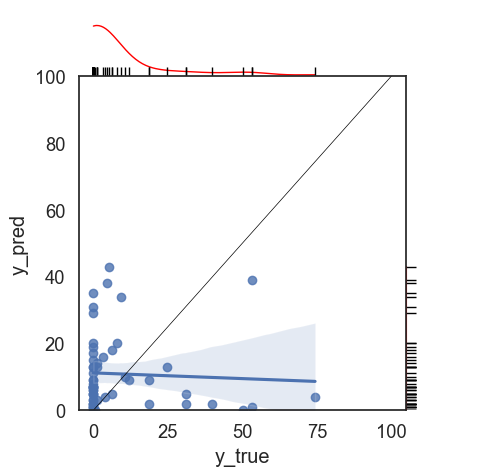

In [52]:
sns.set(style='white', font_scale=1.2)


g = sns.JointGrid(
    x=df_y_true_pred["y_true"], y=df_y_true_pred["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
                )
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


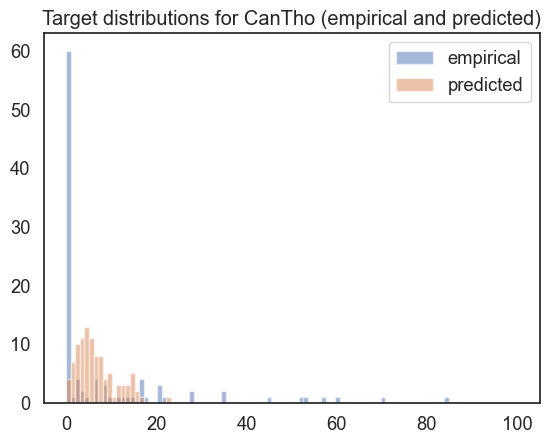

In [182]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.5, label='empirical')
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.title("Target distributions for CanTho (empirical and predicted)")
plt.show()


### get relative content loss estimations (chance * degree of loss)

In [183]:
## df_y_true_pred  # degree of damages
## y_cantho_proba_damage # chance that instance is a damage-case

## reset index of damage cases to match with the index from predicted chance of loss
df_y_true_pred.set_index(idx_damage, inplace =True)

## get estimation of relative content loss
y_pred_rcloss = df_y_true_pred["y_pred"] * y_cantho_proba[0].reset_index(drop=True)  # risk = damage [%] * chance [0,1]
## add zero-loss cases
y_pred_rcloss = y_pred_rcloss.fillna(0.0)
y_pred_rcloss

## df with observed rclosses and predicted rclosses
cantho_y_true_pred_rcloss = pd.concat([df_cantho_y, y_pred_rcloss], axis=1)
cantho_y_true_pred_rcloss.columns = ["rcloss_true", "rcloss_pred"]
cantho_y_true_pred_rcloss.describe()

,rcloss_true,rcloss_pred
count,279.000000,279.000000
mean,9.896200,2.492578
std,18.508807,4.232230
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,10.586915,4.000000
max,98.841419,23.000000


## Evaluation of rcloss estimations -Can THo

In [184]:
rcloss_true = cantho_y_true_pred_rcloss["rcloss_true"]
rcloss_pred = cantho_y_true_pred_rcloss["rcloss_pred"]

# evaluation metrics
MAE = em.mean_absolute_error(rcloss_true, rcloss_pred)
MBE = em.mean_bias_error(rcloss_true, rcloss_pred)
RMSE = em.root_mean_squared_error(rcloss_true, rcloss_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = em.symmetric_mean_absolute_percentage_error(rcloss_true, rcloss_pred)


print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

MAE,: 10.787946169708041
MAE, MBE, RMSE, SMAPE: 10.787946169708041 7.403622191833491 20.563119623773545 59.691437876107464


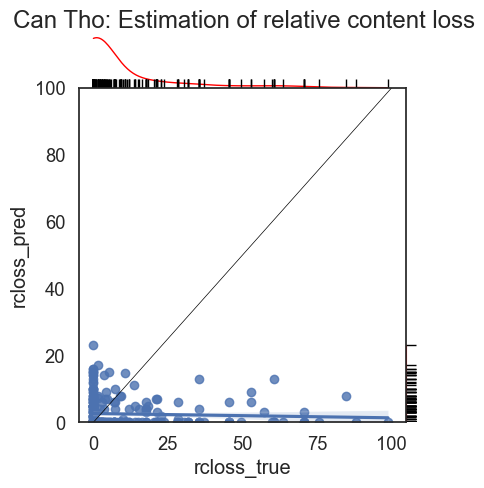

In [185]:
sns.set(style='white', font_scale=1.2)

g = sns.JointGrid(
    x=rcloss_true, 
    y=rcloss_pred, 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
                )
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.suptitle("Can Tho: Estimation of relative content loss")
plt.show()

In [188]:

### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
print(em.empirical_vs_predicted(rcloss_true, rcloss_pred))


# # ### Plot prediction error from outer cv
# f.plot_residuals(
#     residuals=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../../model_results/models_evaluation/degree_of_loss/residuals_{target}.png"
# )


           nobs  median      mean  min max  variance
empirical   279     0.0  9.709677  [0, 98]    337.49
predicted   279     0.0  2.358423  [0, 23]     16.81


In [187]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target], bins, alpha=0.5, label='hcmc rcloss')
# plt.hist(df_cantho[target], bins, alpha=0.5, label='cantho rcloss')
# plt.legend(loc='upper right')
# plt.title("Target distributions for both cities (empirical)")
# plt.show()
